## Proyecto 1 - Etapa 1

### Integrantes

- Nicolas Diaz Montaña / n.diaz9 / 202021006
- Sebastian Casanova
- Julio Peña
   

## 1. Importacion de librerias  y Carga de Datos

In [75]:
## %pip install num2words
## %pip install ydata-profiling
## %pip install pattern
%pip install imbalanced-learn
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [169]:
import numpy as np
import pandas as pd

import num2words
import re, unicodedata, inflect
import nltk
from pattern.es import parse, split
from gensim.models import Word2Vec
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

In [77]:
import warnings
warnings.filterwarnings("ignore")

In [78]:
import matplotlib.pyplot as plt

In [79]:
PRINT_RECALL = "Recall:"
PRINT_PRECISION = "Precision:"
PRINT_F1 = "F1:"

In [80]:
# Configuring pandas to show all cell content
pd.set_option("display.max_colwidth", None)

In [81]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elfue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elfue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [83]:
reviews_df = pd.read_csv("../data/tipo1_entrenamiento_estudiantes.csv")

#### 1.1 Entendimiento de Datos

In [84]:
reviews_df.shape

(7875, 2)

In [85]:
reviews_df.sample(5)

,Review,Class
2896,"magnífica comida, servicio rápido, gran ambiente, personal simpático, ¡me encantó! Si estás en la zona, este es un viaje que merece la pena! Espero volver otra vez.",5
6259,"La plaza de armas es una de las 4 plazas principales de La Habana vieja. Esta el palacio de gobierno a un lado, el castillo de La Real Fuerza por otro y una especie de ""panteón"" que fue la piedra fundacional de la ciudad. La plaza está bordeada por muchos vendedores de libros ambulantes, algunos autores independientes.",4
6171,Buen día. Un saludo. Lo que no me pareció que el clima no sirviera y que tuvo que asistir un técnico. Que en el estacionamiento hay una fuga de agua con mal olor. No tienen ventanas más grandes para poder fumar.,3
1683,"Espectacular el lugar y las personas de seguridad y bar geniales. Ambiente espectacular, las bebidas y comidas geniales. Súper recomendado para disfrutar en pareja. Disfruta de la vista y el lugar …….",5
5325,"Me parece un lugar muy acogedor, excelente servicio al cliente, la comida muy exquisita y con muy buenos precios.",5


In [86]:
reviews_df["Class"].value_counts(dropna=False, normalize=True)

Class
5    0.298413
4    0.250286
3    0.199111
2    0.148952
1    0.103238
Name: proportion, dtype: float64

In [87]:
textos = reviews_df.copy()
textos['Conteo'] = [len(x) for x in textos['Review']]
textos['Moda'] = [pd.Series(x).value_counts().index[0] for x in textos['Review']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Review']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [88]:
reviews_df["Review"] = reviews_df["Review"].astype(str)

En los datos estan 7875 resgistros, cada uno representando una review con su clasificacion respectiva de algun lugar turisiticos. La columna de `Review` son de tipo texto y, tal como dice su nombre, contiene las opiniones de distintos turistas acerca de los lugares vacacionales que visitaron. Estas opiniones pueden dar una idea de las caracterisitcas de estos lugares. Por otro lado, la columna `Class` es de tipo numerico y nos da la clasificacion del 1 al 5, siendo 1 la puntuacion mas baja y 5 la mas alta, para los lugares turisticos. Esta es nuestra variable objetivo.  

Por el lado de la clasificacion, los lugares turisticos que tienen una clasificacion de 5 representan un 29.8% de los datos; los que tienen una clasificacion de 4, un 25.0%; los que tiene 3, un 19.9%; los que tienen 2, un 14.9%; 10.3%, las que tiene clasificacion de 1.

Con respecto a la completitud, los datos estan excelentes. No se encuentra datos nulos, afortunadamente, lo cual facilita la preparacion de los datos y se tendra un mejor resultado en el analisis. Aun asi, los datos cuentan con un 0,5% de datos repetidos, lo cual representan 38 reviews repetidas. 

En terminos de conteo se tuvo un minimo de review de 33 palabras, un review de maximo de 14129 y una mediana de 217 en el conjunto de datos analizado. Contando con un promedio de 407.94 palabras por review. A sue vez, se tienen un maximo promedio de 13.2 caracteres en las palabras de un review y un minimo, en promedio, de por lo menos un caracter en una palabra. 

Para la moda, se tiene que las palabras que mas aparecen son `stop words`, palabras que son de uso comun en el lenguaje pero que no aportan mucho en el analisis, solo generan ruido. Estas palabras pueden ser: "que", "de", "y", "es", entre otras. Aun asi, se puede ver que los tambien hay palabras relevantes para el caso que se esta trabajando tal como: "servicio", "habitacion", "comida", entre otras. Este analisis se describira mas detalladamente mas adelante en la preparacion de los datos.



## 2. Preparacion de Datos

Para poder empezar el pre-procesamiento de los datos es recomendable realizar las siguientes etapas: Limpieza de los datos, tokenizar y normalizar.

### 2.1. Limpieza de los datos

Para empezar toca eliminar y remplazar cualquier ruido que nos puede generar informacion poco relevante, o conflictos en el peor de los casos, a la hora de hacer el analisis de texto, tales como: 
* Palabras que no esten en ASCII (eliminar), ya que como el texto esta en español pueden haber tildes.
* Palabras que tengan mayusculas (volver minusculas), para que el programa no se confunda y tome dos palabras iguales como diferentes por tener mayusculas.
* Puntuacion (eliminar) , ya que estas no se cuenta como palabras en si y no nos daria informacion relevante.
* Reseñas repetidas (eliminar), para que no genere sesgos o redundancia en el analisis.
* Palabras Stop (eliminar), para eliminar palabras comunes que generan ruido en los datos y que no aportan al análisis.

In [89]:
def remove_non_ascii(words):
    """Remueve las palabras que no sean ASCII de una lista de palabras 
    tokenizadas"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convierte todos los caracteres de una lista de palabras 
    tokenizadas a minusculas"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Elimina la puntuacion de una lista de palabras 
    tokenizadas"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Reemplaza los números de una lista de palabras tokenizadas por una representación textual"""
    new_words = []
    for word in words:
        try:
            if word.isdigit():
                new_word = num2words(int(word), lang='es')
                new_words.append(new_word)
            else:
                new_words.append(word)
        except ValueError:
            # En caso de que el valor no sea un dígito, simplemente añadir la palabra original
            new_words.append(word)
    return new_words
    
def remove_stopwords(words):
    """Elimina las 'stopwords' de una lista de palabras 
    tokenizadas"""
    return [word for word in words if word not in stop_words]

def preprocessing(words):
    words = to_lowercase(words)
    # words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [90]:
reviews_df.duplicated().any()

True

In [91]:
reviews_df_final = reviews_df.drop_duplicates()

In [92]:
reviews_df_final.duplicated().any()

False

### 2.2. Normalizacion

Toca tomar en cuenta que hay varios aspectos de la normalizacion que pueden hacer parte de la limpieza de datos, y viceversa. En nuestro caso, se hara lemmatizacion y stematizacion. Lematizar debido a que tiene en cuenta el contexto y la gramática del texto para encontrar la forma basica de una palabra. Esto ayuda a preservar el significado original de las palabras, lo que puede ser crucial para comprender las opiniones expresadas en las reseñas. Ademas, de que ayuda a reducir la variabilidad léxica y resaltar de manera más efectiva las características de los lugares turísticos.

Por otro lado, se stemmatiza dado a que este simplifica el texto al reducir las palabras a su forma raíz, lo que a su vez ayuda a identificar patrones. Al agrupar palabras similares bajo una misma raíz, se reduce la dimensionalidad del conjunto de datos, lo que ayuda a identificar aspectos relevantes y comunes en las reseñas. Esto permite una comprensión más clara de las características que hacen que un sitio turístico sea atractivo o no para los visitantes.






In [93]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = nltk.stem.SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = nltk.WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = lemmatize_verbs(words)
    words = stem_words(words)
    return words

### 2.3. Tokenizacion

Se realiza la tokenizacio dado a que ayuda a capturar la estructura el significado y caracteristicas relevantes del texto, lo cual es nos ayuda en el contexto del  negocio dado a que queremos evidenciar las caracteristicas mas relevantes de los lugares turisticos. Separar las frases en palabras por medio de apply y una función que tokeniza. Una vez toquenizado se aplican las funciones de limpieza de datos y normalizacion. 

In [94]:
reviews_df_final["Review"] = reviews_df_final["Review"].apply(word_tokenize).apply(preprocessing).apply(normalize).apply(" ".join)
reviews_df_final.sample(5)

,Review,Class
6914,mejor hotel mejor instal mism preci recom viej hic entrar puert servici igual sal cambi habit regader tap extractor suci anos cancel regader rechin colg instal ve remodel dentr ve cos recom,1
4167,camin bord ciud amurall espectaluc vist mejor ir dia noch igual geniald preferent quedens hosped centr histor,5
4638,experient mal nadi ayud baj mal estacion pid ayud lueg bellboy groser estacion groser toall huel horribl can regres recomend cam comod si cuart estan bien,2
1677,restaur excelent hiz tan popul visit cad diciembr insist ir ultim visit diciembr 2016 gran decepcion mayor espaci agrad servici adecu com embarg sombr soli produc si llev yucatec plac sos cutr viv yucat 16 anos hab com varied lugar sirv com local mas memor sol tortill hech man dificil consegu suficient comidam,3
4524,pued dec verdader sign falt estil comun hermos tan tipic pais comun lugar aburr,2


### 2.4. Análisis y ultimos ajustes

Se va a revisar las palabras mas frecuentes de los diferentes tipos de reseñas con el fin de encontrar Stopwords. Para eso se utilizara un WordCloud, el cual es una representación visual de las palabras más frecuentes en un conjunto de texto, donde el tamaño de cada palabra es proporcional a su frecuencia en el texto. Las palabras se muestran en forma de nube, donde las palabras más frecuentes suelen aparecer más grandes y destacadas. La idea es ver cuales palabras comunes, que no aportan mucho significado al texto, estan en los tipos reseñas y si estas estan o no repetidas entre las diferentes clasificaciones. Todo esto con el fin de mejorar la precision de los modelos.

#### 2.4.1 Clase 1

In [95]:
data_class_1 = reviews_df_final.loc[reviews_df_final['Class']==1]

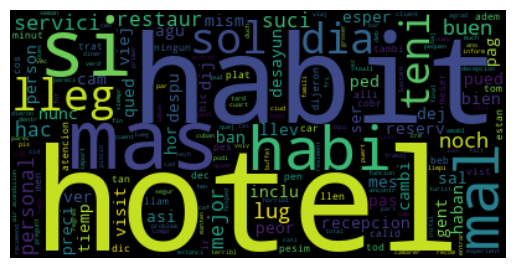

In [96]:
wc = WordCloud().generate("".join(data_class_1["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.2 Clase 2

In [97]:
data_class_2 = reviews_df_final.loc[reviews_df_final['Class']==2]

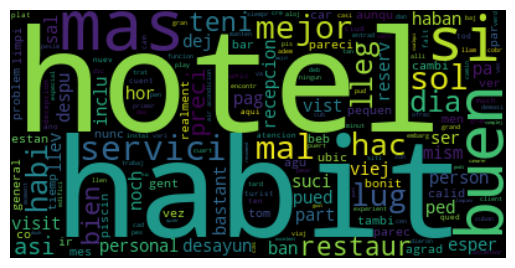

In [98]:
wc = WordCloud().generate("".join(data_class_2["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.3 Clase 3

In [99]:
data_class_3 = reviews_df_final.loc[reviews_df_final['Class']==3]

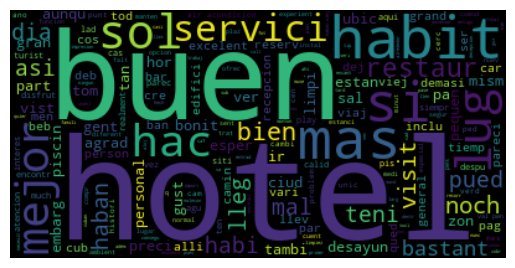

In [100]:
wc = WordCloud().generate("".join(data_class_3["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.4 Clase 4

In [101]:
data_class_4 = reviews_df_final.loc[reviews_df_final['Class']==4]

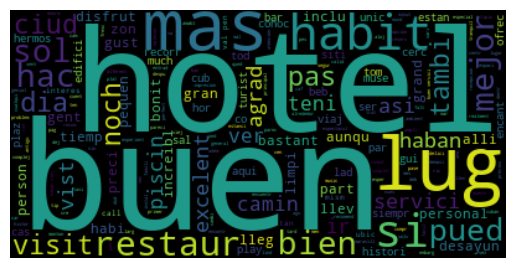

In [102]:
wc = WordCloud().generate("".join(data_class_4["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.5 Clase 5

In [103]:
data_class_5 = reviews_df_final.loc[reviews_df_final['Class']==5]

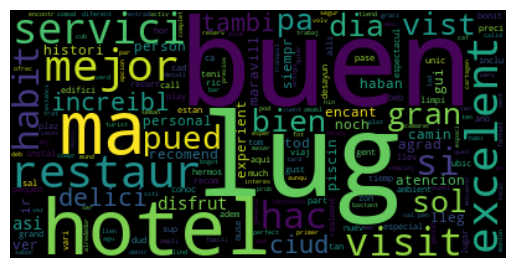

In [104]:
wc = WordCloud().generate("".join(data_class_5["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.4.6 Ajustes finales

Se lograron idetificar las siguientes palabras:
- si
- ser
- cada
- hotel
- habit
- mas
- lug

Estas palabras son las que mas frecuencia tenian Y que se compartian entre las clases de reseñas. Muchas de estas palabras pueden ser redudantes en el contexto del problema dado a que son lugares turisticos, ademas de que algunas de ellas pueden tener significado disitinto dependiendo como lo es la palabras `mas`. 

La idea ahora, es eliminar estas palabras del dataframe y dejar los datos listos para los modelos.

In [105]:
stop_words.append("si")
stop_words.append("ser")
stop_words.append("cada")
stop_words.append("hotel")
stop_words.append("habit")
stop_words.append("mas")
stop_words.append("lug")

In [106]:
reviews_df_final["Review"] = reviews_df_final["Review"].apply(word_tokenize).apply(remove_stopwords).apply(" ".join)

In [107]:
reviews_df_final.sample(5)

,Review,Class
3337,excelent opcion com tom trag escuch buen music haban viej medi cuadr plaz viej call murall buen divert music logr pas bien plat vari,5
3036,quier hac fil encontr mes restaur principal encontr sill piscin sombrill l play instal lind desafortun dan bast cantid person van pes personal nadi ayud organiz cuart habi cucarach,2
3024,aunqu rio artificial ciud realment limpi restaur alrededor dan encant romant noch,5
4089,antigu fortalez fos sol par dolar ver ampli muestr artefact marit histor inclu histori descubr tesor hund personal muse extrem servicial orgull ayud explic respond pregunt,4
2136,llev do trayect autobus ir centr ciud viej zon romant puert vallart barat cualqu taxi personal maravill esfuerz maxim tan servicial posibl activ personal realment hac posibl asegur mund content goz beb bastant agu car happy hours noch tard econom compr cervez liqour oxxo walmart meg chedauri llev piscin estan buen aunqu jacuzzi sid realment agrad,3


## 3. Entrenamiento

In [108]:
# The param 'stratify' is useful to guarantee label proportions on train and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews_df_final[["Review"]], reviews_df_final["Class"], test_size=0.3, stratify=reviews_df_final["Class"], random_state=1)

In [109]:
X_train_tokens = [nltk.word_tokenize(text) for text in X_train]
X_test_tokens = [nltk.word_tokenize(text) for text in X_test]

In [110]:
X_train.shape, X_test.shape

((5462, 1), (2342, 1))

In [111]:
pd.Series(y_train).value_counts(normalize=True)

Class
5    0.299707
4    0.251556
3    0.199011
2    0.148663
1    0.101062
Name: proportion, dtype: float64

In [112]:
pd.Series(y_test).value_counts(normalize=True)

Class
5    0.299744
4    0.251494
3    0.198975
2    0.148591
1    0.101196
Name: proportion, dtype: float64

## 4.  Vectorizacion de Texto

In [113]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [114]:
X_bow = bow.fit_transform(X_train["Review"])

In [115]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 12253


El modelo TF-IDF (Term Frequency-Inverse Document Frequency) es una técnica utilizada en el procesamiento de lenguaje natural (NLP) para analizar la importancia de una palabra en un documento en relación con una colección de documentos. Es comúnmente utilizado en tareas de minería de texto, recuperación de información y clasificación de texto. En el contexto del negocio, TF-IDF puede ser utilizado para identificar las palabras clave y características más relevantes que contribuyen a la evaluación de un lugar turístico. 

In [116]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [117]:
X_tfidf = tfidf.fit_transform(X_train["Review"])

In [118]:
print("Vocabulary size:", len(tfidf.vocabulary_))

Vocabulary size: 12253


## 5. Modelos y Algoritmos

### 5.1. Modelo Random Forest en conjunto con TF-IDF (Nicolas Diaz Montaña)

En este escenario, el algoritmo de Random Forest emerge como una herramienta valiosa para realizar un análisis independiente de los conjuntos de datos de reseñas de sitios turísticos. Principalmente, gracias al manejo robusto que tiene frente al sobreajuste en conjuntos de datos complejos, el Random Forest puede proporcionar información crucial sobre la importancia de diversas características en la calificación de los turistas. Esta interpretación de las características podría ayudar a identificar áreas de mejora en los sitios turísticos y diseñar estrategias efectivas que puede ser de interes para los stakeholders.

In [119]:
tfidf_model = RandomForestClassifier(random_state=3)

In [120]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

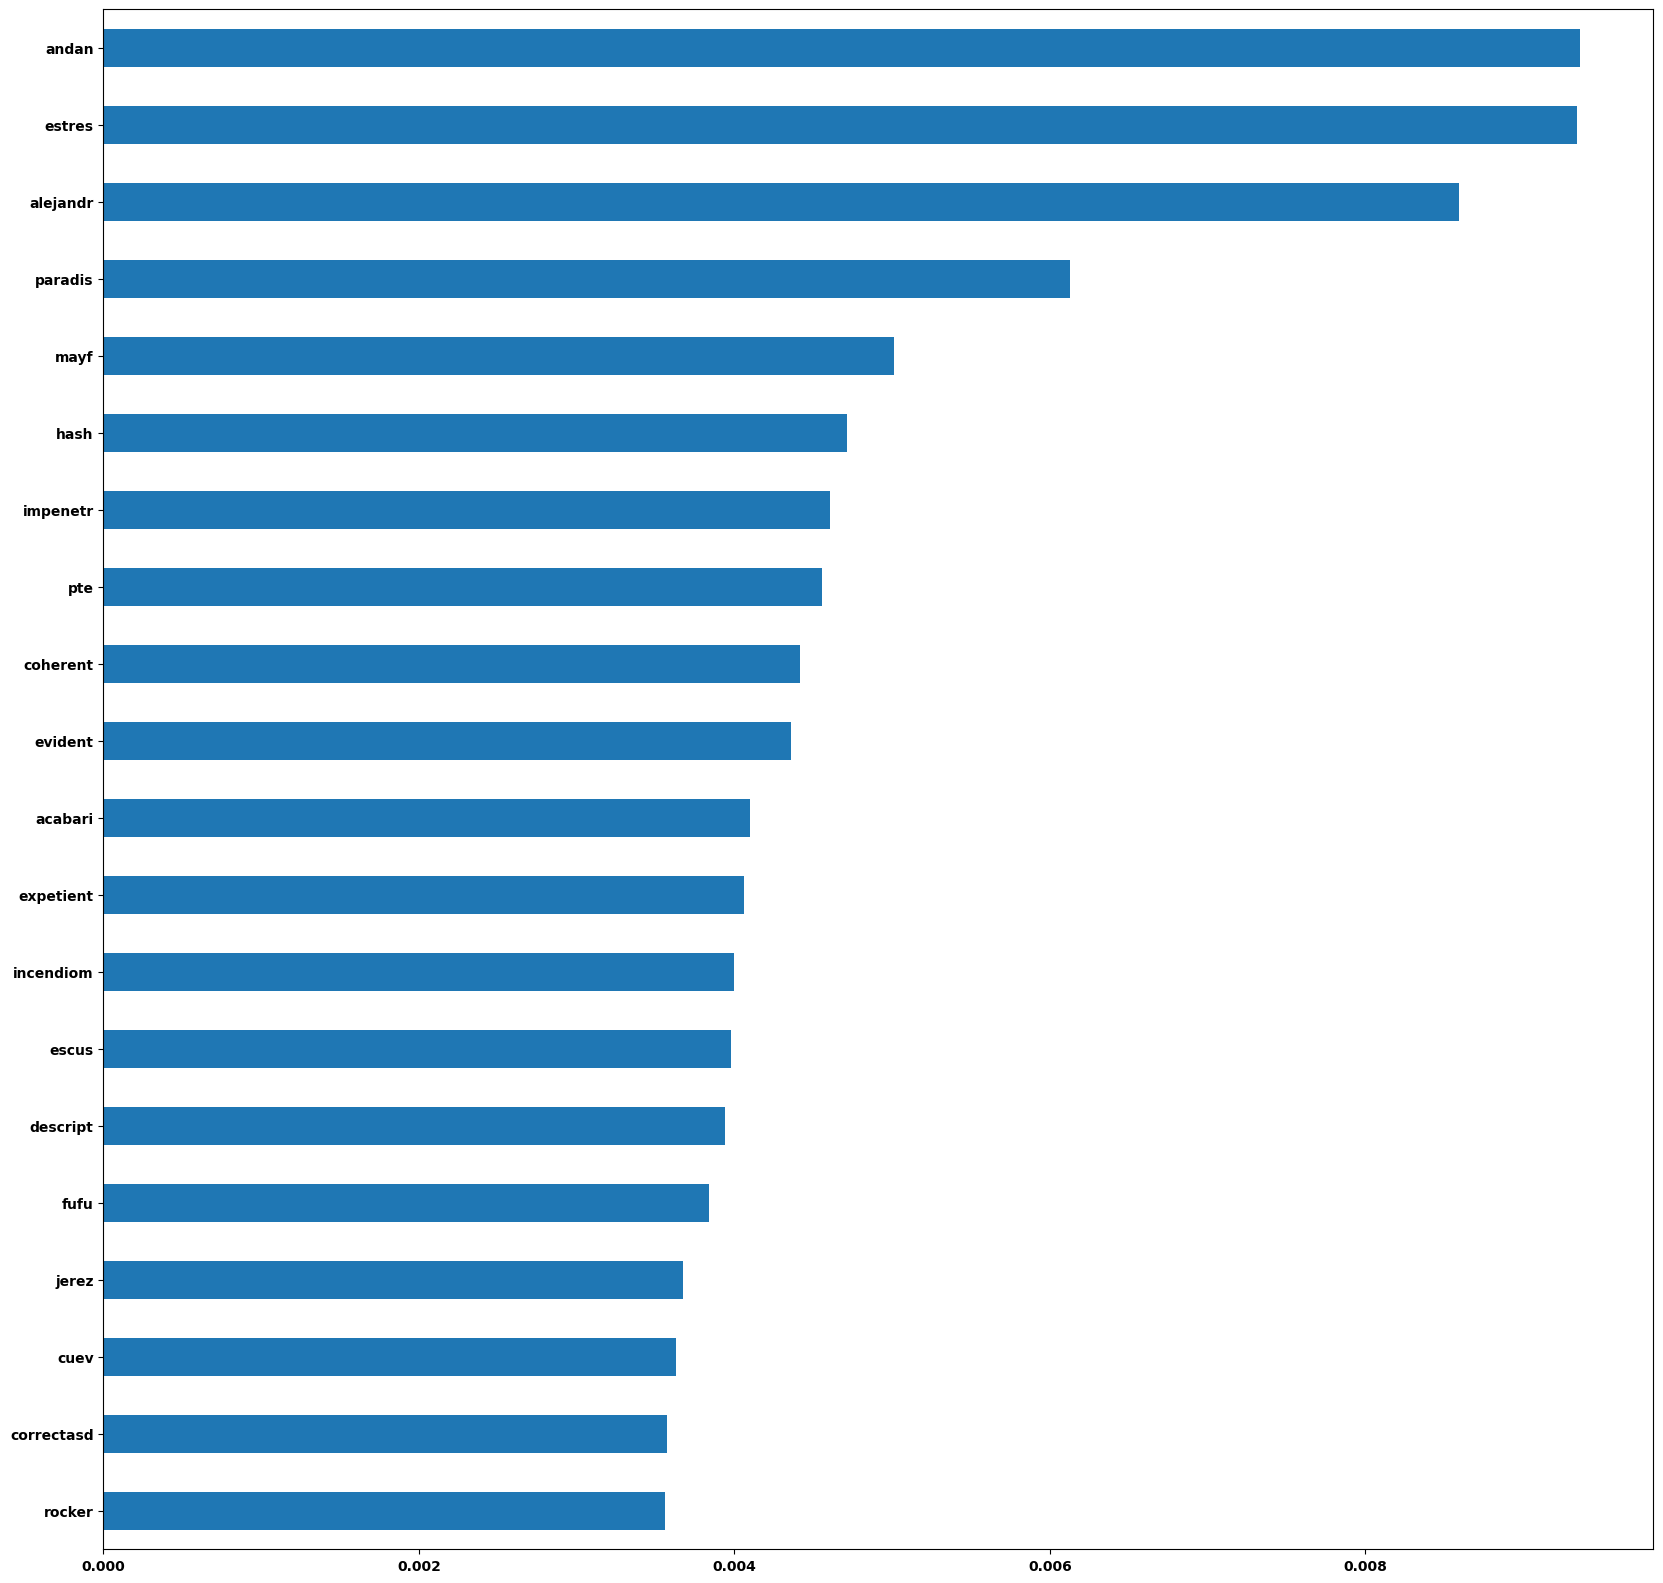

In [121]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(20, 20))

In [122]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 246.14


In [123]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test["Review"]))

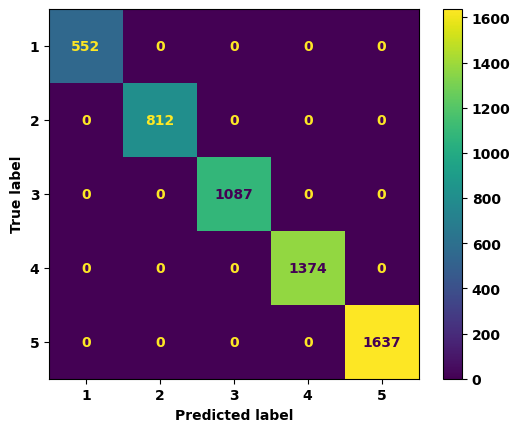

In [124]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

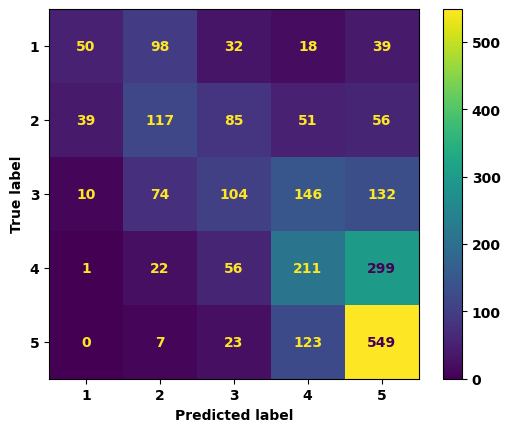

In [125]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [126]:
print(PRINT_PRECISION, precision_score(y_train, y_train_tfidf_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_tfidf_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_tfidf_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [127]:
print(PRINT_PRECISION, precision_score(y_test, y_test_tfidf_predict, average="weighted"))  
print(PRINT_RECALL, recall_score(y_test, y_test_tfidf_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_tfidf_predict, average="weighted"))

Precision: 0.4239827396031862
Recall: 0.4402220324508967
F1: 0.4147367976462558


### 5.2 Modelo BoW (Julio Alexander Peña Tovar)

Bag of words (BoW) es una técnica de procesamiento de texto que convierte documentos de texto en vectores numéricos, ignorando el orden de las palabras. Primero, construye un vocabulario a partir de todas las palabras diferentes en nuestro conjunto de datos. Luego, para cada review en nuestra conjunto de datos, cuenta la frecuencia de cada palabra y construye un vector donde cada elemento representa el número de ocurrencias de una palabra específica en la review. Esto resulta en una matriz donde cada fila representa una review y cada columna representa una palabra única del vocabulario.

In [128]:
bow_model = RandomForestClassifier(random_state=2)

In [129]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

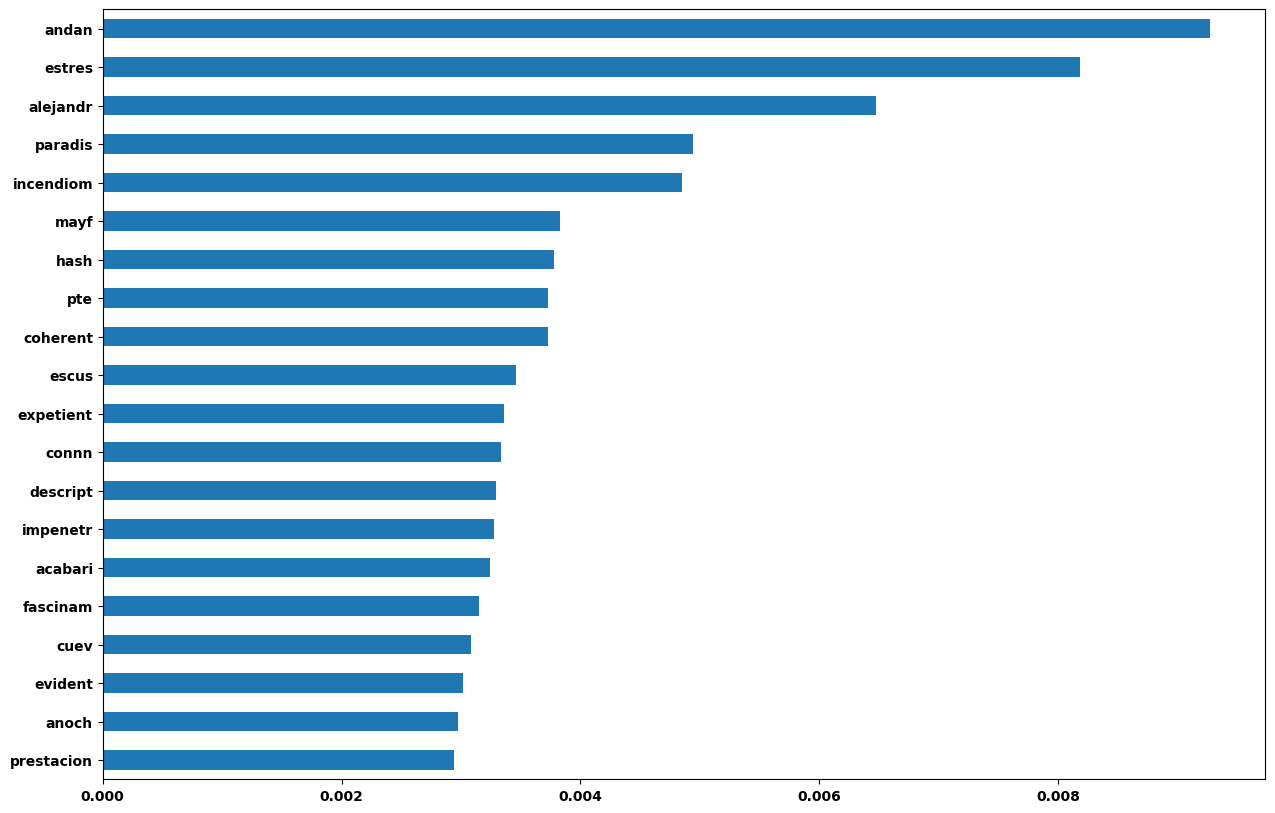

In [130]:
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [131]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 251.35


In [132]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Review"]))

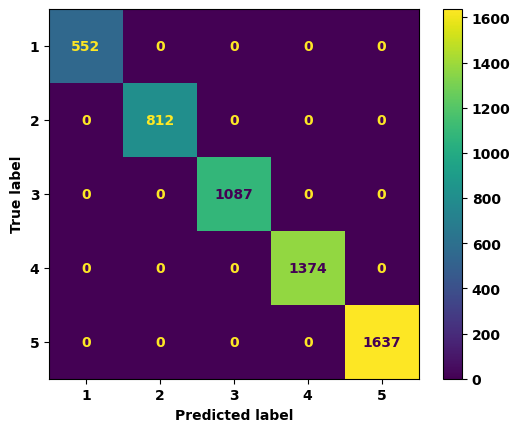

In [133]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

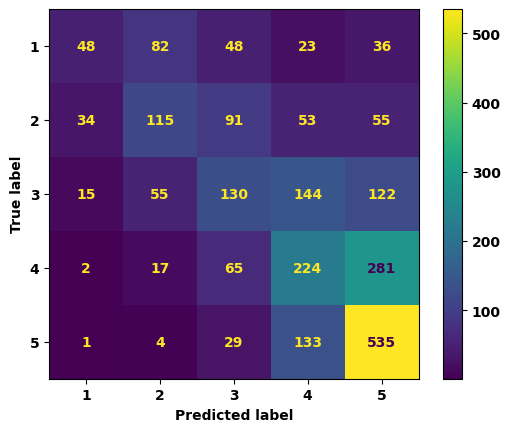

In [134]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [135]:
print(PRINT_PRECISION, precision_score(y_train, y_train_bow_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_bow_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_bow_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [136]:
print(PRINT_PRECISION, precision_score(y_test, y_test_bow_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_test, y_test_bow_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_bow_predict, average="weighted"))

Precision: 0.4359028439503338
Recall: 0.44918872758326217
F1: 0.4281783483317698


### 5.3 Modelo Naive Bayes en conjunto con TF-IDF (Nicolas Diaz Montaña)

Naive Bayes permite clasificar las reseñas en categorías de sentimiento, mientras que TF-IDF ayuda a identificar las características únicas de cada sitio turístico a partir de las palabras utilizadas en las reseñas. Juntos, estos métodos proporcionan una visión integral de los factores que influyen en la atracción y recomendación de los sitios turísticos.

In [137]:
clf_NB = MultinomialNB()

In [138]:
clf_NB.fit(X_tfidf, y_train)

MultinomialNB()

<Axes: ylabel='Palabra'>

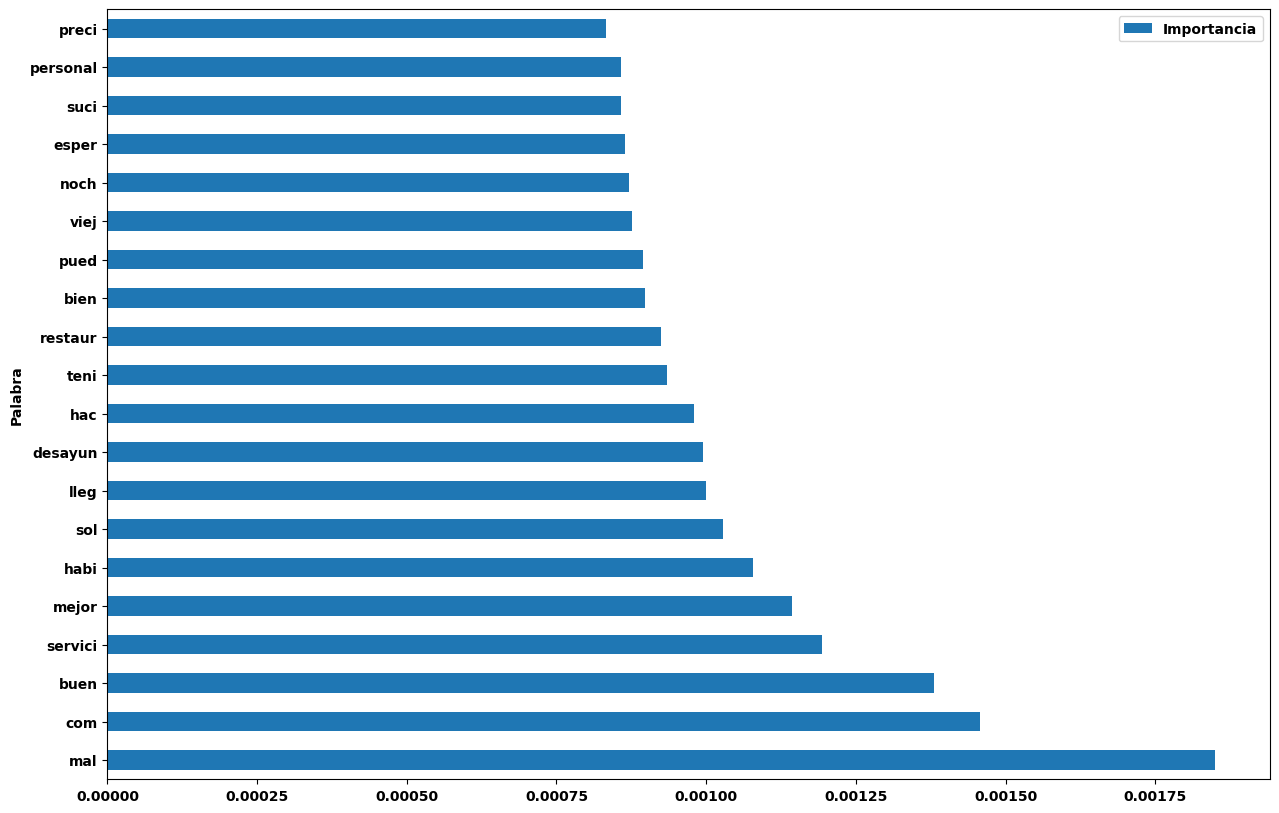

In [139]:
# Obtener las probabilidades logarítmicas de cada clase
log_probs = clf_NB.feature_log_prob_

# Obtener el nombre de las características (palabras)
vocabulario = tfidf.get_feature_names_out()

# Crear un DataFrame para almacenar las palabras y sus importancias
palabras_importantes = pd.DataFrame({"Palabra": vocabulario, "Importancia": np.exp(log_probs[1])})

# Ordenar las palabras por importancia
palabras_importantes = palabras_importantes.sort_values(by="Importancia", ascending=False).reset_index(drop=True)

# Visualizar las palabras más importantes en forma de gráfico de barras
palabras_importantes.head(20).plot.barh(x="Palabra", y="Importancia", figsize=(15, 10))

In [140]:
y_train_NB_predict = clf_NB.predict(X_tfidf)
y_test_NB_predict = clf_NB.predict(tfidf.transform(X_test["Review"]))

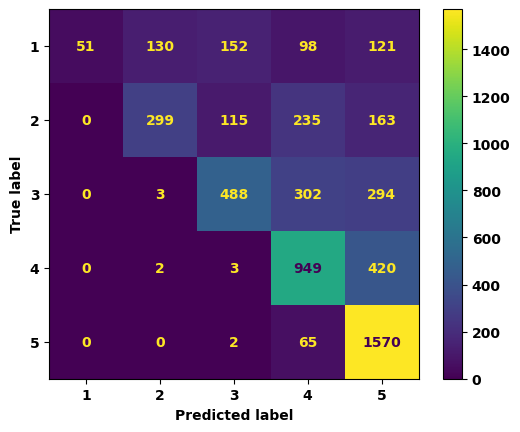

In [141]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_NB_predict)

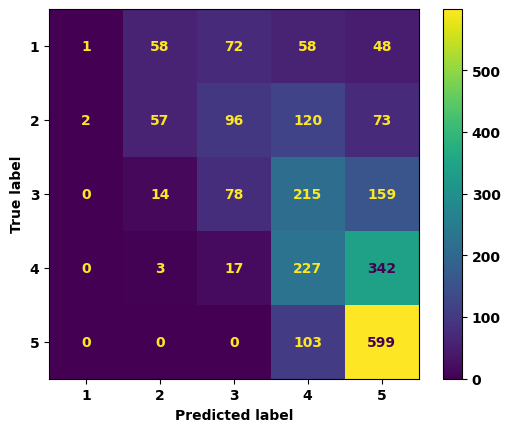

In [142]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_NB_predict)

In [143]:
print(PRINT_PRECISION, precision_score(y_train, y_train_NB_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_NB_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_NB_predict, average="weighted"))

Precision: 0.6592711562496926
Recall: 0.6146100329549615
F1: 0.5753470783802339


In [144]:
print(PRINT_PRECISION, precision_score(y_test, y_test_NB_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_test, y_test_NB_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_NB_predict, average="weighted"))

Precision: 0.38291816153283453
Recall: 0.4107600341588386
F1: 0.3524748620008873


### 5.4 Modelo de regresión (Sebastián Casanova Ospina)

Teniendo en cuenta los objetivos que se buscan resolver para la organización, es evidente la necesidad de poder predecir la calificación que un turista le dará al lugar turistico visitado. Esto con diferentes fines que pueden beneficiar al negocio como lo es saber que lugares son preferidos por los turistas o también saber en que poder mejorar los lugares para que los turistas tengan una mejor experiencia.

Se dice que la regresión es lineal dado que se asume una relación lineal entre las variables de entrada (features) y la variable objetivo (target).

En Scikit-Learn existen varias formas de implementar el algoritmo de regresión lieal, para la elaboración de este proyecto se usará la implementacioón LinearRegression. 

#### 5.4.1 Preparación de los datos

In [145]:
# Split de datos
X_train, X_test, y_train, y_test = train_test_split(reviews_df_final["Review"], reviews_df_final["Class"], test_size=0.3, random_state=1)
# Vectorización de texto
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [151]:
X_train_tfidf.shape, y_train.shape

((5462, 12048), (5462,))

In [152]:
X_test_tfidf.shape, y_test.shape

((2342, 12048), (2342,))

#### 5.4.2 Selección del modelo

Dado la naturaleza del problema es natural asumir que existe una relación lineal entre las variables independeientes (las reseñas) y la variable dependiente (la calificación). Es por lo anterior que una regresión lineal puede ser lo mas conveniente para los propositos y objetivos de la organización.

In [146]:
# Inicialización del modelo de regresión lineal
regression_model = LinearRegression()

#### 5.4.3 Entrenamiento del modelo

In [147]:
# Entrenamiento del modelo
regression_model.fit(X_train_tfidf, y_train)

LinearRegression()

#### 5.4.4 Interpretación del intercepto


El intercepto en un modelo de regresión lineal representa el valor esperado de la variable dependiente cuando todas las variables independientes son iguales a cero.

En el contexto del turismo y el análisis de las características de los destinos turísticos, el intercepto podría proporcionar información sobre la calificación promedio que se espera para un destino turístico si no se tienen en cuenta ninguna de las características analizadas.

In [160]:
regression_model.intercept_

3.354628842430011

Analisando el resultado del intercepto de nuestro modelo podemos inferir que incluso cuando no hay una reseña o una reseña con información relevante se espera una calificación aceptable para el destino turistico.

#### 5.4.5 Evaluación del modelo

In [168]:
# Predicciones en datos de entrenamiento y prueba
y_train_pred = regression_model.predict(X_train_tfidf)
y_test_pred = regression_model.predict(X_test_tfidf)

# Métricas de evaluación
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("----------------------------------")
print("Train R^2:", train_r2)
print("Test R^2:", test_r2)
print("----------------------------------")
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 0.000184334195312032
Test RMSE: 1.6958265156376433
----------------------------------
Train R^2: 0.9999999807928573
Test R^2: -0.6763351326725344
----------------------------------
Train MAE: 0.00010544564783822757
Test MAE: 1.328140935944971


#### Análisis cuantitativo
1. Los resultados del modelo de regresión lineal son bastante llamativos. El error cuadrático medio (RMSE) en el conjunto de entrenamiento es extremadamente bajo, lo que sugiere que el modelo ajusta muy bien los datos de entrenamiento. Sin embargo, el RMSE en el conjunto de prueba es significativamente mayor, lo que indica que el modelo no generaliza bien a datos no vistos, lo cual es una preocupación importante.
2. El coeficiente de determinación (R^2) en el conjunto de entrenamiento es cercano a 1, lo que sugiere que el modelo explica casi toda la variabilidad de los datos de entrenamiento. Sin embargo, el R^2 en el conjunto de prueba es negativo, lo que indica que el modelo es peor que un modelo que simplemente predice la media de los datos de prueba. Esto sugiere un problema de sobreajuste en el modelo.
3. El error absoluto medio (MAE) también muestra una diferencia significativa entre el conjunto de entrenamiento y prueba, lo que refuerza la idea de que el modelo no generaliza bien a nuevos datos.

#### Análisis cualitativo
1.  El modelo de regresión lineal logra capturar eficazmente la relación entre las características de las reseñas turísticas y las calificaciones proporcionadas por los turistas en el conjunto de entrenamiento.
2.  La presencia de un intercepto significativo en el modelo sugiere que hay un efecto base que contribuye a las calificaciones turísticas, independientemente de otras características. Esto proporciona una base sólida para identificar y comprender los factores clave que influyen en la percepción y satisfacción de los turistas con los destinos turísticos.


## 6. Prueba del modelo

Teniendo en cuenta las indicaciones que se nos dieron, pasaremos a asignar calificaciones a un documento con solo reseñas, para evaluar su calidad.

In [178]:
# Cargar el nuevo conjunto de datos con solo reseñas
nuevas_reseñas_df = pd.read_csv("../data/particion_prueba_estudiantes.csv")

Haremos un pequeño arreglo a alos datos y los prepararemos para posteriormente evaluarlos.

In [179]:
# Preprocesamiento de las nuevas reseñas
nuevas_reseñas_df["Review"] = nuevas_reseñas_df["Review"].apply(word_tokenize).apply(preprocessing).apply(normalize).apply(" ".join)

# Vectorización de las nuevas reseñas
X_nuevas_reseñas_tfidf = tfidf.transform(nuevas_reseñas_df["Review"])

Posteriormente haremos la prediccion de las calificaciones.

In [183]:
# Predicción de las calificaciones
calificaciones_predichas = regression_model.predict(X_nuevas_reseñas_tfidf)

# Truncar las calificaciones predichas para que estén dentro del rango de 0 a 5
calificaciones_predichas_truncadas = np.clip(calificaciones_predichas, 0, 5)

Debemos guardar las calificaciones y exportarlo a un documento.

In [184]:
# Asignación de las calificaciones predichas al nuevo conjunto de datos
nuevas_reseñas_df["Class"] = calificaciones_predichas_truncadas

# Guardar el nuevo conjunto de datos con las calificaciones asignadas
nuevas_reseñas_df.to_csv("../data/nuevas_reseñas_con_calificaciones.csv", index=False)